# Data Challenge 2022 : Real estate price prediction
Nous avons choisi de relever le défi "Prévision des prix de l'immobilier" proposé par l'Institut Louis Bachelier. 
Nous avons divisé le travail en 4 sections : 
- Section I   : Nous allons aborder le problème en nous appuyant uniquement sur l'ensemble des données tabulaires (fichiers csv fournis).
- Section II  : Nous allons nous adresser au problème en ajoutant des caractéristiques géographiques à partir de l'api google places.
- Section III : Nous ajouterons des variables extraites des images fournies et mettrons en œuvre NIMA (Neural Network Image Assesment).
- Section IV  : Nous allons créer un pipeline de prétraitement et optimiser nos résultats pour le classement de manière reproductible.

In [ ]:
!python -m pip install -r requirements.txt

Avant de commencer, nous allons charger toutes les bibliothèques nécessaires que nous allons utiliser pendant ce défi.

In [70]:
import pandas as pd
import lightgbm as lgb
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,RobustScaler
import scipy as sp
from scipy.stats import skew
from pycaret.regression import compare_models, setup
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.impute import SimpleImputer,IterativeImputer
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import optuna 
from optuna.pruners import MedianPruner, PatientPruner
from optuna.visualization import plot_optimization_history, plot_param_importances
from dataprep.eda import plot, plot_missing, plot_correlation, create_report
from pycaret.regression import *
import os
import googlemaps
from tqdm import tqdm
from geopy.distance import geodesic
import pandas as pd
from PIL import Image
import pandas as pd
import fuzzywuzzy.process as fwp
from unidecode import unidecode
from tqdm import tqdm

# only import this if you want to execute section 4 (must clone the repository)
from tools.preprocess import *



pd.options.display.max_rows=50
pd.options.display.max_columns=90

# Section I :  

## 1. Exploration et analyse des données:
Dans cette section, nous allons charger nos données, les explorer, les analyser et essayer d'en extraire des informations significatives avant de leur appliquer des étapes de prétraitement.

In [48]:
# Loading the Data
filepath='data/'

# Raw Loaded data
X_train_raw=pd.read_csv(filepath +'X_train_J01Z4CN.csv') 
Y_train_raw=pd.read_csv(filepath + 'y_train_OXxrJt1.csv')

#Y_test_raw=pd.read_csv(filepath + 'y_random_MhJDhKK.csv')
X_test_raw=pd.read_csv(filepath + 'X_test_BEhvxAN.csv')

# Droping ids for training
X_train_0=X_train_raw.drop(columns="id_annonce")
Y_train_0=Y_train_raw.drop(columns="id_annonce")

X_test_0=X_test_raw.drop(columns="id_annonce")

# Saving Test ids for prediction
X_test_ids=X_test_raw["id_annonce"]
X_test_ids.to_pickle("data/X_test_ids.pkl")



In [49]:
print(f" Number of training rows : {X_train_0.index.max()}")
print(f" Numer of testing rows : {len(X_test_0.index)}")

 Number of training rows : 37367
 Numer of testing rows : 9339


In [50]:
X_train_0.head()

property_type  approximate_latitude  approximate_longitude  \
0   appartement             43.643880               7.117183   
1   appartement             45.695757               4.895610   
2        maison             47.966791              -1.220451   
3        maison             47.289292              -1.878805   
4   appartement             45.718992               4.844234   

                city  postal_code   size  floor  land_size  \
0  villeneuve-loubet         6270   63.0    NaN        NaN   
1         venissieux        69200   90.0    3.0        NaN   
2           moutiers        35130   61.0    NaN      370.0   
3          cordemais        44360  142.0    NaN      764.0   
4          lyon-7eme        69007   88.0    3.0        NaN   

   energy_performance_value energy_performance_category  ghg_value  \
0                       NaN                         NaN        NaN   
1                     223.0                           D       52.0   
2                       NaN                         NaN        NaN   
3                     217.0                           D       44.0   
4                       NaN                         NaN        NaN   

  ghg_category exposition  nb_rooms  nb_bedrooms  nb_bathrooms  \
0          NaN        NaN       3.0          2.0           NaN   
1            E        NaN       5.0          4.0           NaN   
2          NaN        Sud       2.0          1.0           NaN   
3            E        NaN       4.0          3.0           NaN   
4          NaN        NaN       4.0          3.0           1.0   

   nb_parking_places  nb_boxes  nb_photos  has_a_balcony  nb_terraces  \
0                0.0       0.0        4.0            0.0          1.0   
1                0.0       0.0        8.0            0.0          0.0   
2                0.0       0.0        4.0            0.0          0.0   
3                0.0       1.0        8.0            0.0          1.0   
4                0.0       1.0        5.0            1.0          0.0   

   has_a_cellar  has_a_garage  has_air_conditioning  last_floor  upper_floors  
0           0.0           0.0                   0.0         0.0           0.0  
1           0.0           0.0                   0.0         0.0           0.0  
2           0.0           0.0                   0.0         0.0           0.0  
3           0.0           0.0                   0.0         0.0           0.0  
4           0.0           0.0                   0.0         0.0           0.0

In [51]:
X_train_0.describe().T.style.background_gradient(subset=['std'], cmap='Reds').background_gradient(subset=['mean'], cmap='Blues')

In [52]:
X_test_0.describe().T.style.background_gradient(subset=['std'], cmap='Reds').background_gradient(subset=['mean'], cmap='Blues')

Nous pouvons déjà remarquer plusieurs valeurs aberrantes dans les différentes variables, par exemple, le nombre moyen de photos dans X_test_0 est de 4,5, alors que le maximum est de 45.

In [54]:
categorical_features = ["property_type","city","energy_performance_category","ghg_category","exposition", "postal_code"]
numerical_features = ["approximate_latitude", "approximate_longitude","size", "floor","land_size","energy_performance_value","ghg_value","nb_rooms","nb_bedrooms","nb_bathrooms","nb_parking_places","nb_boxes","nb_photos","nb_terraces"]
boolean_features = ["has_a_cellar","has_a_garage", "has_air_conditioning", "last_floor", "upper_floors"]

### a. Cardinalité des variables

In [55]:
# Train set features cardinality
train_cardinality = (pd.Series({feature: len(X_train_0[feature].unique()) for feature in X_train_0[categorical_features]})
                     .reset_index().rename(columns={'index':'Feature',0:'Cardinality'}))
sb.set(rc={"figure.figsize":(5, 6)})

# Test set features cardinality
test_cardinality = (pd.Series({feature: len(X_test_0[feature].unique()) for feature in X_test_0[categorical_features]})
                     .reset_index().rename(columns={'index':'Feature',0:'Cardinality'}))
sb.set(rc={"figure.figsize":(5, 6)})

In [56]:
(pd.merge(train_cardinality,test_cardinality, on='Feature', how='left')
 .sort_values(by=['Cardinality_x', 'Cardinality_y'], ascending=[False,False])
 .rename(columns={'Cardinality_x':'Train Cardinality','Cardinality_y':'Test Cardinality'}))

Feature  Train Cardinality  Test Cardinality
1                         city               8643              3833
5                  postal_code               4726              2964
0                property_type                 22                20
4                   exposition                 13                13
2  energy_performance_category                  8                 8
3                 ghg_category                  8                 8

In [57]:
(pd.Series(X_train_0.isna().sum()/len(X_train_0.index)*100).reset_index().
    rename(columns={'index':'Feature',0:'Missing_Values'}).
    sort_values(by=['Missing_Values'], ascending=[False]))



Feature  Missing_Values
12                   exposition       75.663669
6                         floor       73.926889
7                     land_size       58.303896
10                    ghg_value       50.412117
11                 ghg_category       50.412117
9   energy_performance_category       48.972383
8      energy_performance_value       48.972383
15                 nb_bathrooms       35.519696
14                  nb_bedrooms        7.313744
13                     nb_rooms        4.190751
5                          size        1.370156
18                    nb_photos        0.000000
22                 has_a_garage        0.000000
21                 has_a_cellar        0.000000
23         has_air_conditioning        0.000000
24                   last_floor        0.000000
20                  nb_terraces        0.000000
19                has_a_balcony        0.000000
0                 property_type        0.000000
17                     nb_boxes        0.000000
16            nb_parking_places        0.000000
1          approximate_latitude        0.000000
4                   postal_code        0.000000
3                          city        0.000000
2         approximate_longitude        0.000000
25                 upper_floors        0.000000

In [48]:
#plot(X_train_0) # 

In [76]:
#plot_correlation(X_train_0)

In [77]:
report=create_report(X_train_0, title='Training Data Report')
report.show_browser()


  0%|                                                  | 0/3546 [00:00<?, ?it/s]

E-1019 (DUPLICATE_FACTORS): FactorRange must specify a unique list of categorical factors for an axis: duplicate factors found: 'approximate_l...ude'


In [13]:
report=create_report(X_test_0, title='Training Data Report')
report.show_browser()


  0%|                                                  | 0/3546 [00:00<?, ?it/s]

E-1019 (DUPLICATE_FACTORS): FactorRange must specify a unique list of categorical factors for an axis: duplicate factors found: 'approximate_l...ude'


## 1. Nettoyage des données
### a. Nettoyage des variables :
Nous avons un ensemble de variables redondantes, par exemple :

- 'energy_performance_category' qui est dérivé de 'energy_performance_value'
- 'ghg_category'  qui est dérivé de 'ghg_value'

nous avons également un problème avec les variables à cardinalité élevée, en particulier 'postal_code' et 'city'.

In [58]:
data = pd.concat([X_train_0, X_test_0], axis=0).reset_index(drop=True)


### b. Traitement des valeurs NaN :

- Pour les maisons, nous fixons la valeur du plancher à 0.
- Pour les appartements, nous fixons la valeur de la taille du terrain à 0.

In [61]:
# Dropping the columns
data_0=data.drop(columns=["energy_performance_category", "ghg_category"])


## 2. Encodage par fréquence

In [71]:
# Frequency encoding
df = data_0.copy()
fq = df.groupby(['city']).size()/len(df)

# mapping values to dataframe
df.loc[:, "{}_freq_encode".format('city')] = df['city'].map(fq)

# drop original column.
df = df.drop(['city'], axis=1)
df = df.rename(columns={"city_freq_encode":"city"})
data_1=df.copy()

## 3. Iterative Imputation

In [82]:
iter_mean = IterativeImputer(estimator=LGBMRegressor(), random_state=0)
data_11=data_1.copy()
iter_mean.fit(data_1)
data_2=iter_mean.transform(data_1)
data_2=pd.DataFrame(data, index=data_0.index, columns=data_11.columns)

In [ ]:
#Set floor value to 0 for all property types that are not appartements
data_2.loc[(data_2['property_type']!="appartement") & data_2['floor'].isna(), 'floor'] = 0

## 4. Hot Encoding


In [83]:
data_4 = pd.get_dummies(data_3)


## 5. Scaling


In [84]:
scaler = RobustScaler()
scaler.fit(data_4)
data_5=pd.DataFrame(scaler.transform(data_4), index=data_4.index, columns=data_4.columns)
data_5.head()

approximate_latitude  approximate_longitude  postal_code      size  \
0             -1.230185               1.728803    -1.643535 -0.184695   
1             -0.359793               0.873048     0.540915 -0.179866   
2              0.603565              -1.482872    -0.641736 -0.185053   
3              0.316174              -1.736472    -0.321341 -0.170565   
4             -0.349936               0.853258     0.534215 -0.180224   

      floor  land_size  energy_performance_value  ghg_value  nb_rooms  \
0 -0.120956  -0.078300                 -0.067279  -0.099833 -0.415909   
1  0.430095  -0.077434                  0.011669   0.051358  0.247776   
2 -0.321338  -0.074476                 -0.090842  -0.039087 -0.747751   
3 -0.321338  -0.062459                  0.004382   0.024360 -0.084066   
4  0.430095  -0.084583                 -0.150114  -0.082959 -0.084066   

   nb_bedrooms  nb_bathrooms  nb_parking_places  nb_boxes  nb_photos  \
0    -0.381082      0.280099          -0.646351 -0.468614  -0.856026   
1     0.530459     -0.573299          -0.646351 -0.468614   0.006854   
2    -0.836853      0.280099          -0.646351 -0.468614  -0.856026   
3     0.074688      0.280099          -0.646351  2.133951   0.006854   
4     0.074688      0.280099          -0.646351  2.133951  -0.640306   

   has_a_balcony  nb_terraces  has_a_cellar  has_a_garage  \
0      -0.417646     1.490434     -0.500054      -0.23856   
1      -0.417646    -0.670945     -0.500054      -0.23856   
2      -0.417646    -0.670945     -0.500054      -0.23856   
3      -0.417646     1.490434     -0.500054      -0.23856   
4       2.394374    -0.670945     -0.500054      -0.23856   

   has_air_conditioning  last_floor  upper_floors      city  \
0               -0.2053   -0.061677     -0.015348 -0.175218   
1               -0.2053   -0.061677     -0.015348 -0.063869   
2               -0.2053   -0.061677     -0.015348 -0.549758   
3               -0.2053   -0.061677     -0.015348 -0.559881   
4               -0.2053   -0.061677     -0.015348 -0.428286   

   property_type_appartement  property_type_atelier  property_type_chalet  \
0                   1.169987              -0.006544             -0.035564   
1                   1.169987              -0.006544             -0.035564   
2                  -0.854710              -0.006544             -0.035564   
3                  -0.854710              -0.006544             -0.035564   
4                   1.169987              -0.006544             -0.035564   

   property_type_chambre  property_type_château  property_type_divers  \
0              -0.011335              -0.023142             -0.245156   
1              -0.011335              -0.023142             -0.245156   
2              -0.011335              -0.023142             -0.245156   
3              -0.011335              -0.023142             -0.245156   
4              -0.011335              -0.023142             -0.245156   

   property_type_duplex  property_type_ferme  property_type_gîte  \
0             -0.078492            -0.058996           -0.009255   
1             -0.078492            -0.058996           -0.009255   
2             -0.078492            -0.058996           -0.009255   
3             -0.078492            -0.058996           -0.009255   
4             -0.078492            -0.058996           -0.009255   

   property_type_hôtel  property_type_hôtel particulier  property_type_loft  \
0            -0.004627                        -0.012243           -0.039293   
1            -0.004627                        -0.012243           -0.039293   
2            -0.004627                        -0.012243           -0.039293   
3            -0.004627                        -0.012243           -0.039293   
4            -0.004627                        -0.012243           -0.039293   

   property_type_maison  property_type_manoir  property_type_moulin  \
0             -0.847753             -0.021209             -0.023142   
1             -0.8

## 6. Target Transformation


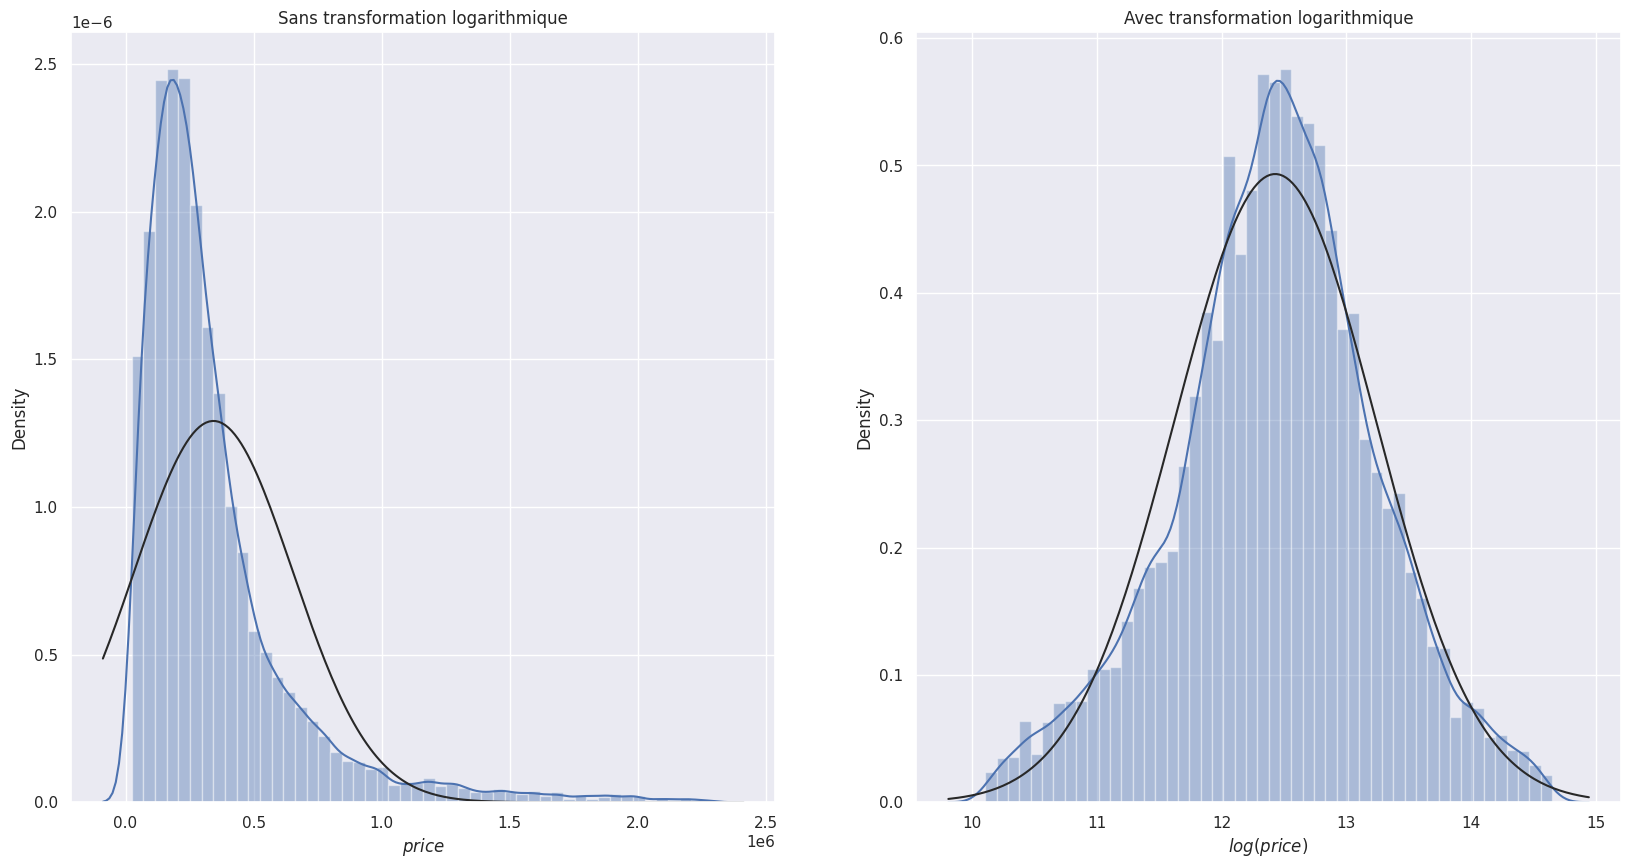

In [85]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sb.distplot(Y_train_0, kde=True, fit=sp.stats.norm)
plt.xlabel("$price$")

plt.title("Sans transformation logarithmique")

plt.subplot(1, 2, 2)
sb.distplot(np.log(Y_train_0), kde=True, fit=sp.stats.norm)
plt.xlabel("$log(price)$")
plt.title("Avec transformation logarithmique")

plt.show()


In [112]:
from sklearn.preprocessing import QuantileTransformer, quantile_transform

y_trans = quantile_transform(
    Y_train_0, n_quantiles=900, output_distribution="normal", copy=True
).squeeze()

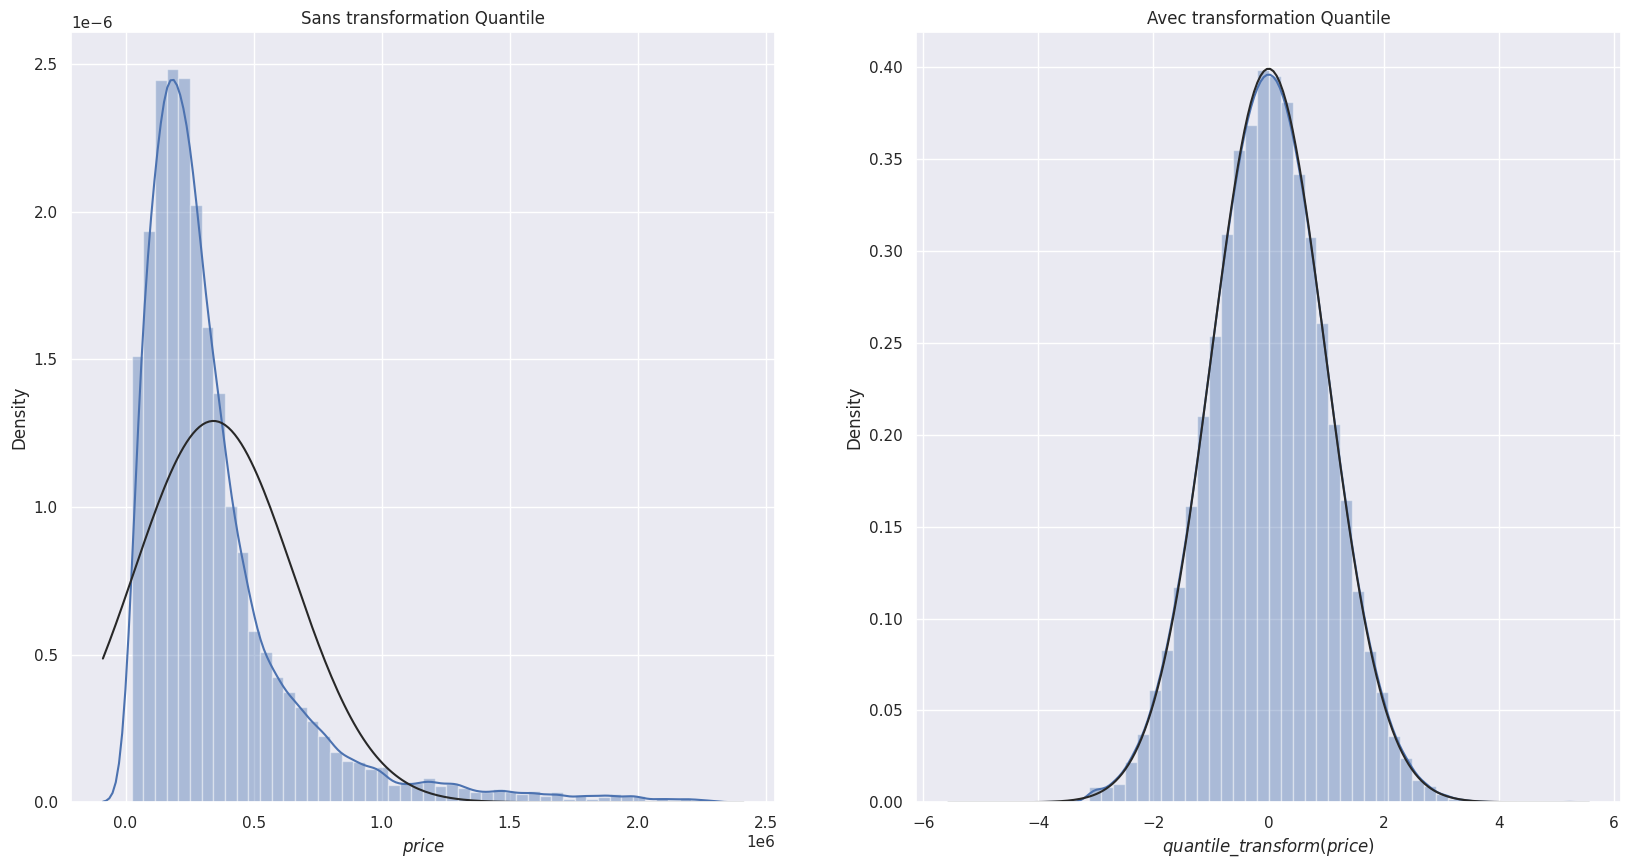

In [115]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sb.distplot(Y_train_0, kde=True, fit=sp.stats.norm)
plt.xlabel("$price$")

plt.title("Sans transformation Quantile")

plt.subplot(1, 2, 2)
sb.distplot(y_trans, kde=True, fit=sp.stats.norm)
plt.xlabel("$quantile\_transform(price)$")
plt.title("Avec transformation Quantile")

plt.show()


In [86]:
Y_train_1=np.log(Y_train_0)

In [87]:
X_train_1=data_5.loc[:X_train_0.index.max(),:]
X_train_1.head()

approximate_latitude  approximate_longitude  postal_code      size  \
0             -1.230185               1.728803    -1.643535 -0.184695   
1             -0.359793               0.873048     0.540915 -0.179866   
2              0.603565              -1.482872    -0.641736 -0.185053   
3              0.316174              -1.736472    -0.321341 -0.170565   
4             -0.349936               0.853258     0.534215 -0.180224   

      floor  land_size  energy_performance_value  ghg_value  nb_rooms  \
0 -0.120956  -0.078300                 -0.067279  -0.099833 -0.415909   
1  0.430095  -0.077434                  0.011669   0.051358  0.247776   
2 -0.321338  -0.074476                 -0.090842  -0.039087 -0.747751   
3 -0.321338  -0.062459                  0.004382   0.024360 -0.084066   
4  0.430095  -0.084583                 -0.150114  -0.082959 -0.084066   

   nb_bedrooms  nb_bathrooms  nb_parking_places  nb_boxes  nb_photos  \
0    -0.381082      0.280099          -0.646351 -0.468614  -0.856026   
1     0.530459     -0.573299          -0.646351 -0.468614   0.006854   
2    -0.836853      0.280099          -0.646351 -0.468614  -0.856026   
3     0.074688      0.280099          -0.646351  2.133951   0.006854   
4     0.074688      0.280099          -0.646351  2.133951  -0.640306   

   has_a_balcony  nb_terraces  has_a_cellar  has_a_garage  \
0      -0.417646     1.490434     -0.500054      -0.23856   
1      -0.417646    -0.670945     -0.500054      -0.23856   
2      -0.417646    -0.670945     -0.500054      -0.23856   
3      -0.417646     1.490434     -0.500054      -0.23856   
4       2.394374    -0.670945     -0.500054      -0.23856   

   has_air_conditioning  last_floor  upper_floors      city  \
0               -0.2053   -0.061677     -0.015348 -0.175218   
1               -0.2053   -0.061677     -0.015348 -0.063869   
2               -0.2053   -0.061677     -0.015348 -0.549758   
3               -0.2053   -0.061677     -0.015348 -0.559881   
4               -0.2053   -0.061677     -0.015348 -0.428286   

   property_type_appartement  property_type_atelier  property_type_chalet  \
0                   1.169987              -0.006544             -0.035564   
1                   1.169987              -0.006544             -0.035564   
2                  -0.854710              -0.006544             -0.035564   
3                  -0.854710              -0.006544             -0.035564   
4                   1.169987              -0.006544             -0.035564   

   property_type_chambre  property_type_château  property_type_divers  \
0              -0.011335              -0.023142             -0.245156   
1              -0.011335              -0.023142             -0.245156   
2              -0.011335              -0.023142             -0.245156   
3              -0.011335              -0.023142             -0.245156   
4              -0.011335              -0.023142             -0.245156   

   property_type_duplex  property_type_ferme  property_type_gîte  \
0             -0.078492            -0.058996           -0.009255   
1             -0.078492            -0.058996           -0.009255   
2             -0.078492            -0.058996           -0.009255   
3             -0.078492            -0.058996           -0.009255   
4             -0.078492            -0.058996           -0.009255   

   property_type_hôtel  property_type_hôtel particulier  property_type_loft  \
0            -0.004627                        -0.012243           -0.039293   
1            -0.004627                        -0.012243           -0.039293   
2            -0.004627                        -0.012243           -0.039293   
3            -0.004627                        -0.012243           -0.039293   
4            -0.004627                        -0.012243           -0.039293   

   property_type_maison  property_type_manoir  property_type_moulin  \
0             -0.847753             -0.021209             -0.023142   
1             -0.8

In [118]:
corr = pd.concat([X_train_1, Y_train_1], axis=1).corr()
corr.style.background_gradient(cmap='coolwarm')


In [88]:
X_test_1=data_5.loc[X_train_0.index.max()+1:,:]
X_test_1.head()

approximate_latitude  approximate_longitude  postal_code      size  \
37368              1.199505               0.348549    -1.784120 -0.170386   
37369              1.057621              -1.391169    -0.120009 -0.111899   
37370              0.234682               1.355954    -0.983306 -0.171817   
37371             -1.206520               1.778253    -1.652907  0.454549   
37372             -1.142990               1.381458    -1.709836 -0.088648   

          floor  land_size  energy_performance_value  ghg_value  nb_rooms  \
37368 -0.321338  -0.061361                  0.103978   0.125604  0.247776   
37369 -0.321338   0.785270                 -0.074809  -0.088359  6.884619   
37370 -0.321338  -0.059982                 -0.031327  -0.033012  0.247776   
37371  0.430095  -0.011293                 -0.004120  -0.090384 -0.747751   
37372 -0.321338   0.286777                  0.015070  -0.033012  0.645986   

       nb_bedrooms  nb_bathrooms  nb_parking_places  nb_boxes  nb_photos  \
37368     0.530459      0.280099          -0.646351  2.133951   0.654014   
37369     3.265084      0.280099          -0.646351  2.133951   2.595495   
37370     0.074688      0.280099          -0.646351 -0.468614  -0.424586   
37371    -0.836853     -0.573299          -0.646351 -0.468614   0.222574   
37372     0.074688     -0.573299          -0.646351 -0.468614   4.752696   

       has_a_balcony  nb_terraces  has_a_cellar  has_a_garage  \
37368      -0.417646     1.490434     -0.500054      -0.23856   
37369       2.394374     1.490434     -0.500054      -0.23856   
37370       2.394374     1.490434      1.999786      -0.23856   
37371      -0.417646    -0.670945     -0.500054      -0.23856   
37372      -0.417646    -0.670945     -0.500054      -0.23856   

       has_air_conditioning  last_floor  upper_floors      city  \
37368               -0.2053   -0.061677     -0.015348 -0.559881   
37369               -0.2053   -0.061677     -0.015348 -0.529513   
37370               -0.2053   -0.061677     -0.015348 -0.559881   
37371               -0.2053   -0.061677     -0.015348  2.284599   
37372               -0.2053   -0.061677     -0.015348 -0.539636   

       property_type_appartement  property_type_atelier  property_type_chalet  \
37368                  -0.854710              -0.006544             -0.035564   
37369                  -0.854710              -0.006544             -0.035564   
37370                   1.169987              -0.006544             -0.035564   
37371                   1.169987              -0.006544             -0.035564   
37372                  -0.854710              -0.006544             -0.035564   

       property_type_chambre  property_type_château  property_type_divers  \
37368              -0.011335              -0.023142             -0.245156   
37369              -0.011335              -0.023142             -0.245156   
37370              -0.011335              -0.023142             -0.245156   
37371              -0.011335              -0.023142             -0.245156   
37372              -0.011335              -0.023142              4.079043   

       property_type_duplex  property_type_ferme  property_type_gîte  \
37368             -0.078492            -0.058996           -0.009255   
37369             -0.078492            -0.058996           -0.009255   
37370             -0.078492            -0.058996           -0.009255   
37371             -0.078492            -0.058996           -0.009255   
37372             -0.078492            -0.058996           -0.009255   

       property_type_hôtel  property_type_hôtel particulier  \
37368            -0.004627                        -0.012243   
37369            -0.004627                        -0.012243   
37370            -0.004627                        -0.012243   
37371            -0.004627                        -0.012243   
37372            -0.004627                        -0.012243   

       property_type_loft  property_type_maison  property_type_manoi

## 7. Sélection des modèles 
Afin de déterminer les modèles à utiliser pour cette tâche de régression, nous allons nous appuyer sur Pycaret, pour tester plusieurs modèles de régression de pointe sur nos données prétraitées.

In [65]:
## Using Pycaret
setup_params={
    "feature_interaction":True,
    "polynomial_features":True,
    "use_gpu":True, 
}
p_data = setup(preprocess=True, silent = True, data = pd.concat([X_train_1, Y_train_1], axis=1), target="price",session_id = 154)

create_model_container: 0
master_model_container: 0
display_container: 1
Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[], target='price',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strategy=...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluster_all', 'passthrough'),
                ('dummy', Dummify(target='price')),
  

In [63]:
from pycaret.regression import *
models()

gpu_param set to False


Name  \
ID                                            
lr                        Linear Regression   
lasso                      Lasso Regression   
ridge                      Ridge Regression   
en                              Elastic Net   
lar                  Least Angle Regression   
llar           Lasso Least Angle Regression   
omp             Orthogonal Matching Pursuit   
br                           Bayesian Ridge   
ard       Automatic Relevance Determination   
par            Passive Aggressive Regressor   
ransac              Random Sample Consensus   
tr                       TheilSen Regressor   
huber                       Huber Regressor   
kr                             Kernel Ridge   
svm               Support Vector Regression   
knn                   K Neighbors Regressor   
dt                  Decision Tree Regressor   
rf                  Random Forest Regressor   
et                    Extra Trees Regressor   
ada                      AdaBoost Regressor   
gbr             Gradient Boosting Regressor   
mlp                           MLP Regressor   
xgboost           Extreme Gradient Boosting   
lightgbm    Light Gradient Boosting Machine   
catboost                 CatBoost Regressor   

                                                  Reference  Turbo  
ID                                                                  
lr              sklearn.linear_model._base.LinearRegression   True  
lasso        sklearn.linear_model._coordinate_descent.Lasso   True  
ridge                     sklearn.linear_model._ridge.Ridge   True  
en        sklearn.linear_model._coordinate_descent.Elast...   True  
lar                  sklearn.linear_model._least_angle.Lars   True  
llar            sklearn.linear_model._least_angle.LassoLars   True  
omp       sklearn.linear_model._omp.OrthogonalMatchingPu...   True  
br                sklearn.linear_model._bayes.BayesianRidge   True  
ard               sklearn.linear_model._bayes.ARDRegression  False  
par       sklearn.linear_model._passive_aggressive.Passi...   True  
ransac         sklearn.linear_model._ransac.RANSACRegressor  False  
tr        sklearn.linear_model._theil_sen.TheilSenRegressor  False  
huber            sklearn.linear_model._huber.HuberRegressor   True  
kr                         sklearn.kernel_ridge.KernelRidge  False  
svm                                sklearn.svm._classes.SVR  False  
knn       sklearn.neighbors._regression.KNeighborsRegressor   True  
dt              sklearn.tree._classes.DecisionTreeRegressor   True  
rf           sklearn.ensemble._forest.RandomForestRegressor   True  
et             sklearn.ensemble._forest.ExtraTreesRegressor   True  
ada       sklearn.ensemble._weight_boosting.AdaBoostRegr...   True  
gbr          sklearn.ensemble._gb.GradientBoostingRegressor   True  
mlp            pycaret.internal.tunable.TunableMLPRegressor  False  
xgboost                        xgboost.sklearn.XGBRegressor   True  
lightgbm                     lightgbm.sklearn.LGBMRegressor   True  
catboost                    catboost.core.CatBoostRegressor   True

In [66]:
top5 = compare_models(n_select = 5)

create_model_container: 20
master_model_container: 20
display_container: 2
[<catboost.core.CatBoostRegressor object at 0x7f48bc065160>, XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', ...), LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0

/home/odeck/miniconda3/envs/data-challenge/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/odeck/miniconda3/envs/data-challenge/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/odeck/miniconda3/envs/data-challenge/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/odeck/miniconda3/envs/data-challenge/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureW

/home/odeck/miniconda3/envs/data-challenge/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/odeck/miniconda3/envs/data-challenge/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/odeck/miniconda3/envs/data-challenge/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/odeck/miniconda3/envs/data-challenge/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureW

/home/odeck/miniconda3/envs/data-challenge/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/odeck/miniconda3/envs/data-challenge/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/odeck/miniconda3/envs/data-challenge/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/odeck/miniconda3/envs/data-challenge/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureW

Nous pouvons conclure que les meilleurs modèles sont catboost, Random Forrest, XGboost, Lightgbm, Extra Trees Regressor. Ce sont les modèles avec lesquels nous allons travailler dans les sections suivantes.

## 8. Optimisation des hyperparamètres
Après avoir défini les modèles, nous allons travailler sur l'optimisation des hyperparamètres, pour cela au lieu de gridsearch ou randomsearch nous allons utiliser Optuna. Nous définirons une fonction objective pour chaque modèle, puis nous lancerons une étude pour obtenir les paramètres optimaux.

In [93]:
kf = KFold(10)

In [95]:
def xgb_objective(trial):
    
    # Dictionary of model parameters (i have refined the original ranges a bit)
    model_params = {
        "tree_method":       trial.suggest_categorical("tree_method", ["auto", "exact"]),
        'learning_rate':     trial.suggest_loguniform("learning_rate", 0.1, 0.4),
        'max_depth':         trial.suggest_int("max_depth", 2, 7), 
        'min_child_weight':  trial.suggest_loguniform("min_child_weight", 0.001, 10),
        'subsample':         trial.suggest_discrete_uniform("subsample", 0.1, 1.0, 0.025),
        'colsample_bytree':  trial.suggest_discrete_uniform("colsample_bytree",  0.1, 1.0, 0.025),
        'colsample_bylevel': trial.suggest_discrete_uniform("colsample_bylevel",  0.1, 1.0, 0.025),
        'gamma':             trial.suggest_loguniform("gamma", 1e-10, 10), 
        'reg_lambda':        trial.suggest_loguniform("reg_lambda", 1e-10, 100),
        'reg_alpha':         trial.suggest_loguniform("reg_alpha", 1e-10, 100),
    }
    
    model = XGBRegressor(**model_params)
    cv_scores = -cross_val_score(model, X_train_1, Y_train_1, scoring='neg_mean_absolute_error', cv=kf)
    return np.mean(cv_scores)



In [96]:
# Prunes trial if fold RMSE in lower half for two consective folds
pruner = PatientPruner(
    MedianPruner(
        n_startup_trials = 5, 
        n_warmup_steps = 0,
        interval_steps = 1,
        n_min_trials = 5,
    ),
    patience = 2
)

In [97]:
xgb_study_mae = optuna.create_study(study_name = 'optimizing_xgboost', pruner = pruner, direction = "minimize")
xgb_study_mae.optimize(xgb_objective, n_trials=100)
xgb_study_mae.best_params

[I 2022-12-03 13:54:32,536] A new study created in memory with name: optimizing_xgboost
[I 2022-12-03 13:54:38,503] Trial 0 finished with value: 0.3516238017258314 and parameters: {'tree_method': 'auto', 'learning_rate': 0.19320315876094732, 'max_depth': 3, 'min_child_weight': 0.02778592142416999, 'subsample': 0.375, 'colsample_bytree': 0.725, 'colsample_bylevel': 0.42500000000000004, 'gamma': 5.685834534725739e-07, 'reg_lambda': 0.5351367827838276, 'reg_alpha': 0.0002764618307388822}. Best is trial 0 with value: 0.3516238017258314.
[I 2022-12-03 13:55:01,278] Trial 1 finished with value: 0.29618665253620097 and parameters: {'tree_method': 'auto', 'learning_rate': 0.1689418638488649, 'max_depth': 7, 'min_child_weight': 0.26630450065585337, 'subsample': 0.35, 'colsample_bytree': 0.625, 'colsample_bylevel': 1.0, 'gamma': 0.38061216995980324, 'reg_lambda': 9.129579074091077e-10, 'reg_alpha': 1.7385913267236758e-05}. Best is trial 1 with value: 0.29618665253620097.
[I 2022-12-03 13:55:09,7

[I 2022-12-03 14:00:22,419] Trial 18 finished with value: 0.3135481289332215 and parameters: {'tree_method': 'auto', 'learning_rate': 0.1427212439334251, 'max_depth': 5, 'min_child_weight': 0.0010196279400186883, 'subsample': 1.0, 'colsample_bytree': 0.75, 'colsample_bylevel': 0.55, 'gamma': 0.09467044120575335, 'reg_lambda': 0.0035947421824619355, 'reg_alpha': 0.10798656840429069}. Best is trial 14 with value: 0.2862669445712493.
[I 2022-12-03 14:00:52,243] Trial 19 finished with value: 0.3156644259526321 and parameters: {'tree_method': 'auto', 'learning_rate': 0.28445030258548953, 'max_depth': 6, 'min_child_weight': 0.04209984416773677, 'subsample': 0.5750000000000001, 'colsample_bytree': 0.925, 'colsample_bylevel': 0.65, 'gamma': 4.454020315463482, 'reg_lambda': 2.4784955515665704e-05, 'reg_alpha': 0.15448223339044018}. Best is trial 14 with value: 0.2862669445712493.
[I 2022-12-03 14:01:07,841] Trial 20 finished with value: 0.32689232781091493 and parameters: {'tree_method': 'auto'

[I 2022-12-03 14:08:38,673] Trial 36 finished with value: 0.2964808516705614 and parameters: {'tree_method': 'auto', 'learning_rate': 0.11664047500969146, 'max_depth': 7, 'min_child_weight': 0.016278195551855997, 'subsample': 0.4, 'colsample_bytree': 0.8250000000000001, 'colsample_bylevel': 0.625, 'gamma': 0.0022632476544075103, 'reg_lambda': 6.320358300945603e-06, 'reg_alpha': 2.7780328806527492e-05}. Best is trial 22 with value: 0.280852039563519.
[I 2022-12-03 14:09:00,367] Trial 37 finished with value: 0.3035805630910146 and parameters: {'tree_method': 'auto', 'learning_rate': 0.18069392167643358, 'max_depth': 6, 'min_child_weight': 0.001861359105066346, 'subsample': 0.875, 'colsample_bytree': 0.475, 'colsample_bylevel': 0.4, 'gamma': 0.024304545302963595, 'reg_lambda': 1.476537143829236e-08, 'reg_alpha': 0.0008840177891331914}. Best is trial 22 with value: 0.280852039563519.
[I 2022-12-03 14:09:31,272] Trial 38 finished with value: 0.33595060052212455 and parameters: {'tree_method

[I 2022-12-03 14:18:13,764] Trial 54 finished with value: 0.28224030472697115 and parameters: {'tree_method': 'exact', 'learning_rate': 0.33245403483476643, 'max_depth': 7, 'min_child_weight': 9.897246237606586, 'subsample': 0.8250000000000001, 'colsample_bytree': 0.875, 'colsample_bylevel': 0.7000000000000001, 'gamma': 1.3405044939698814e-07, 'reg_lambda': 3.771653228566923e-08, 'reg_alpha': 7.0075311390018085}. Best is trial 46 with value: 0.27968230856549414.
[I 2022-12-03 14:18:37,184] Trial 55 finished with value: 0.2866939345109555 and parameters: {'tree_method': 'exact', 'learning_rate': 0.36545930530955995, 'max_depth': 6, 'min_child_weight': 7.5514774920345085, 'subsample': 0.8250000000000001, 'colsample_bytree': 0.875, 'colsample_bylevel': 0.7000000000000001, 'gamma': 1.126965139217434e-07, 'reg_lambda': 2.846669490381846e-10, 'reg_alpha': 6.602125208681346}. Best is trial 46 with value: 0.27968230856549414.
[I 2022-12-03 14:19:06,634] Trial 56 finished with value: 0.29411941

[I 2022-12-03 14:26:52,989] Trial 72 finished with value: 0.27764520878640614 and parameters: {'tree_method': 'exact', 'learning_rate': 0.24501402962903027, 'max_depth': 7, 'min_child_weight': 0.7259751507247879, 'subsample': 1.0, 'colsample_bytree': 0.75, 'colsample_bylevel': 0.85, 'gamma': 1.0530257844372348e-10, 'reg_lambda': 2.222533521279192e-10, 'reg_alpha': 1.9519730062254774}. Best is trial 66 with value: 0.27701278996746487.
[I 2022-12-03 14:27:31,171] Trial 73 finished with value: 0.2771669764978614 and parameters: {'tree_method': 'exact', 'learning_rate': 0.25961062159667553, 'max_depth': 7, 'min_child_weight': 0.6729013193845549, 'subsample': 1.0, 'colsample_bytree': 0.75, 'colsample_bylevel': 0.8, 'gamma': 2.3100208138949957e-09, 'reg_lambda': 3.1070562714170327e-10, 'reg_alpha': 1.325906092210104}. Best is trial 66 with value: 0.27701278996746487.
[I 2022-12-03 14:28:11,231] Trial 74 finished with value: 0.27687820608412217 and parameters: {'tree_method': 'exact', 'learni

[I 2022-12-03 14:37:55,964] Trial 90 finished with value: 0.2889057659367332 and parameters: {'tree_method': 'exact', 'learning_rate': 0.2229116008132736, 'max_depth': 6, 'min_child_weight': 0.5191255623173135, 'subsample': 0.9, 'colsample_bytree': 0.7000000000000001, 'colsample_bylevel': 0.85, 'gamma': 2.899637102369986e-09, 'reg_lambda': 1.6440810865112605e-10, 'reg_alpha': 3.237740950428937}. Best is trial 74 with value: 0.27687820608412217.
[I 2022-12-03 14:38:58,134] Trial 91 finished with value: 0.2776821595278679 and parameters: {'tree_method': 'exact', 'learning_rate': 0.27285514370935404, 'max_depth': 7, 'min_child_weight': 0.23286728557481765, 'subsample': 0.9500000000000001, 'colsample_bytree': 0.85, 'colsample_bylevel': 0.9, 'gamma': 1.811111551600264e-09, 'reg_lambda': 2.3791251570586787e-09, 'reg_alpha': 1.1073280390275635}. Best is trial 74 with value: 0.27687820608412217.
[I 2022-12-03 14:39:51,701] Trial 92 finished with value: 0.27727307828659314 and parameters: {'tre

{'tree_method': 'exact',
 'learning_rate': 0.2584647465400957,
 'max_depth': 7,
 'min_child_weight': 0.22505233439069805,
 'subsample': 0.925,
 'colsample_bytree': 0.775,
 'colsample_bylevel': 1.0,
 'gamma': 9.092607717714808e-10,
 'reg_lambda': 8.714870794600981e-09,
 'reg_alpha': 1.3435996778463264}

In [ ]:
plot_optimization_history(xgb_study_mae).show()


In [ ]:
plot_param_importances(xgb_study_mae)


In [ ]:
def cat_objective(trial):
    
    model_params = {
        "learning_rate":trial.suggest_loguniform("learning_rate", 0.05, 0.4),
        "objective": trial.suggest_categorical("objective", ["MAE", "RMSE"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "used_ram_limit": "8gb",
        "verbose":False,
    }
    

    if model_params["bootstrap_type"] == "Bayesian":
        model_params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif model_params["bootstrap_type"] == "Bernoulli":
        model_params["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        

    model = CatBoostRegressor(**model_params)
    model.fit(X_train_1, Y_train_1)
    cv_scores = -cross_val_score(model, X_train_1, Y_train_1, scoring='neg_mean_absolute_error', cv=kf)
    return np.mean(cv_scores)


cat_study = optuna.create_study(study_name = 'optimizing_cat', pruner = pruner, direction = "minimize")
cat_study.enqueue_trial(
{
    'learning_rate': 0.16061323320208248,
    'objective': 'RMSE',
    'colsample_bylevel': 0.08887583406260055,
    'depth': 12,
    'boosting_type': 'Plain',
    'bootstrap_type': 'MVS'
    }
)
cat_study.optimize(cat_objective, n_trials=200)
cat_study.best_params

In [ ]:
plot_optimization_history(cat_study).show()

In [ ]:
plot_param_importances(xgb_study_mae)

In [ ]:
def objective_lgb(trial):

    model_params = {
        "objective": "mape",
        "metric": "mae",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    model = LGBMRegressor(**model_params)
    model.fit(X_train_1, Y_train_1)
    cv_scores = -cross_val_score(model, X_train_1, Y_train_1, scoring='neg_mean_absolute_error', cv=kf)
    return np.mean(cv_scores)



In [ ]:
lgb_study = optuna.create_study(study_name = 'optimizing_lgb', pruner = pruner, direction = "minimize")
lgb_study.enqueue_trial(lgb_params
)
lgb_study.optimize(objective_lgb, n_trials=150)
lgb_study.best_params

In [113]:
def objective_lgb(trial):

    model_params = {
        "objective": "mape",
        "metric": "mae",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    model = lgb.LGBMRegressor(**model_params)
    model.fit(X_train_1, Y_train_1)
    cv_scores = -cross_val_score(model, X_train_1, Y_train_1, scoring='neg_mean_absolute_error', cv=kf)
    return np.mean(cv_scores)



In [ ]:
lgb_study = optuna.create_study(study_name = 'optimizing_lgb', pruner = pruner, direction = "minimize")
lgb_study.optimize(objective_lgb, n_trials=100)
lgb_study.best_params

In [53]:
xgb_params={'tree_method': 'auto',
 'learning_rate': 0.22502761577232197,
 'max_depth': 7,
 'min_child_weight': 2.8420515790248526,
 'subsample': 0.975,
 'colsample_bytree': 0.75,
 'colsample_bylevel': 0.925,
 'gamma': 0.001531824642793309,
 'reg_lambda': 0.010527402680638263,
 'reg_alpha': 1.2647545029756599e-08}


cat_params={
    'learning_rate': 0.24447854966066342,
    'objective': 'RMSE',
    'colsample_bylevel': 0.09999300796304286,
    'depth': 12,
    'boosting_type': 'Plain',
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.9709524520446949
}

tuned_models = {
    "xgboost":XGBRegressor(**xgb_params),
    "etr":ExtraTreesRegressor(),
    "cat":CatBoostRegressor(**cat_params, verbose=False)
}


for model_name, model in tuned_models.items():
    model.fit(X_train_1, Y_train_1)
    print(f"Finished Training {model_name}.")


Finished Training xgboost.
Finished Training etr.
Finished Training cat.


## 9. Importance des variables avec SHAP (SHapley Additive exPlanations) 

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


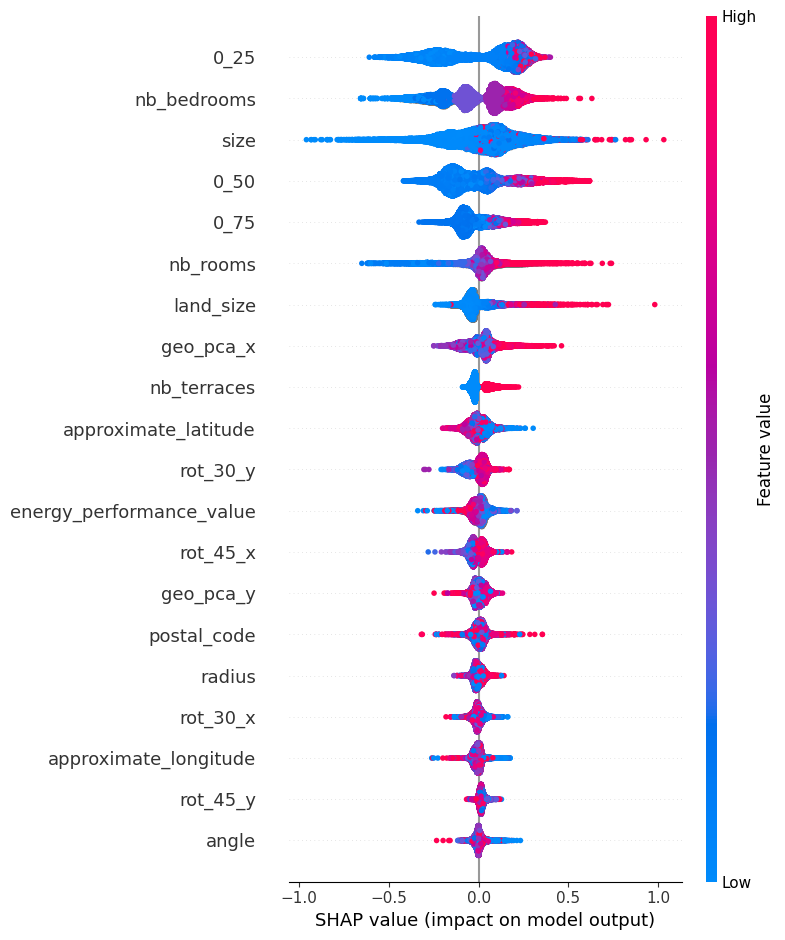

In [12]:
explainer = shap.TreeExplainer(baseline_model)
shap_values = explainer.shap_values(X_train_1)
shap.summary_plot(shap_values, X_train_1)


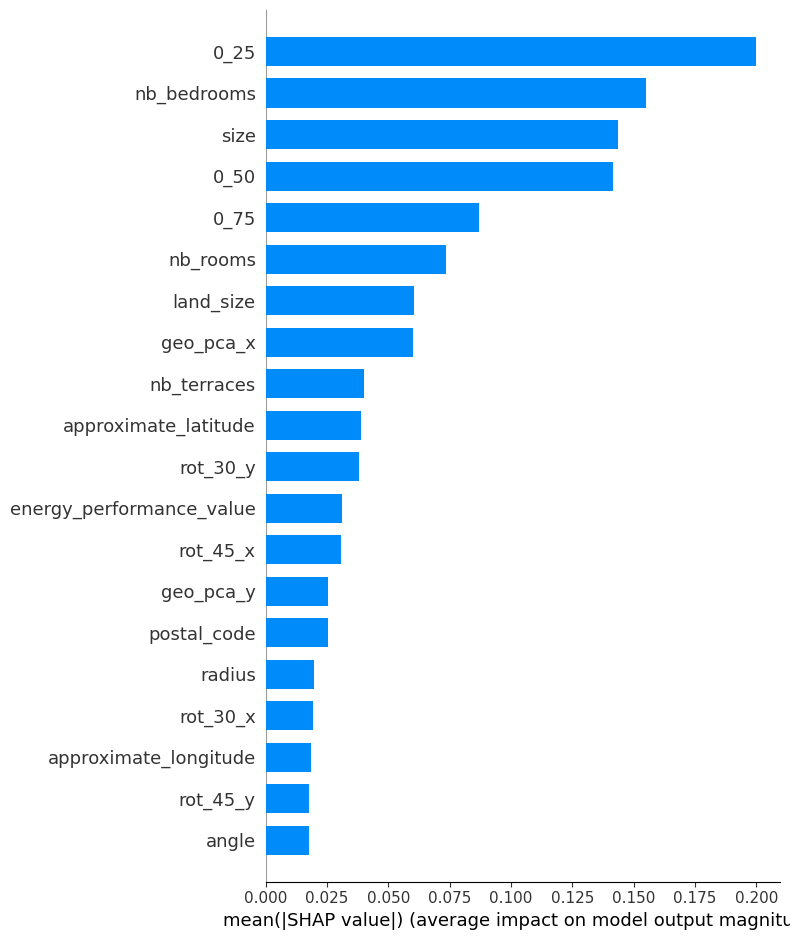

In [13]:
shap.summary_plot(shap_values, X_train_1, plot_type="bar")


# Section II : 
## Ingénierie des variables : Ajout de données géographiques et de variables.
Dans cette section, nous ajouterons des caractéristiques basées sur la localisation en utilisant google maps (places API) afin d'extraire des caractéristiques utiles, par exemple le nombre d'hôpitaux à proximité du domaine, le nombre de gares, le nombre d'écoles, etc.
## 1. Téléchargement de géodonnées
Tout d'abord, nous avons créé un compte dans la console google cloud, et activé "places api", notre clé api est stockée dans un fichier nommé "api".

In [67]:
API_KEY=open("api").read()

In [68]:
map_client = googlemaps.Client(API_KEY)

# Function to download the data about nearest locations/buisness to the estate object based on latitude and longtitude
def get_data(id_annonce, location, distance = 5000):
    business_list = []
    response = map_client.places_nearby(
        location=location,
        radius=distance
    )   

    business_list.extend(response.get('results'))
    next_page_token = response.get('next_page_token')

    while next_page_token:
        time.sleep(0.3)
        try :
            response = map_client.places_nearby(
                location=location,
                radius=distance,
                page_token=next_page_token
            )   
            business_list.extend(response.get('results'))
            next_page_token = response.get('next_page_token')
        except Exception as e:
            # print(e)
            break
    df = pd.DataFrame(business_list)
    df['id_annonce']=id_annonce
    return df

API queries_quota: 60


In [ ]:
final_results = pd.DataFrame({})
for index, row in tqdm(X_train_0.iterrows()):
    results_per_row = get_data(row['id_annonce'], (row['approximate_latitude'],row['approximate_longitude']))
    final_results=pd.concat([results_per_row, final_results], axis=0)
    final_results.to_pickle("X_train_resultsfinal_results = pd.DataFrame({})


## 2. Processing the raw geodata

In [69]:
import pandas as pd
import numpy as np
import geopy.distance
from dataprep.eda import plot, plot_missing, plot_correlation, create_report

# Uploading Training and Test set
X_test_0 = pd.read_csv("data/X_test_BEhvxAN.csv")
X_test_0= X_test_0.sort_values(by="id_annonce")

X_train_0 = pd.read_csv("data/X_train_J01Z4CN.csv")
X_train_0 = X_train_0.sort_values(by="id_annonce")
Y_train_0 = pd.read_csv("data/y_train_OXxrJt1.csv")
Y_train_0 =Y_train_0.sort_values(by="id_annonce")

In [ ]:
def preprocess_geodata(X_test_raw, X_test_geodata):
    
    df =pd.merge(X_test_geodata,X_test_raw, how="left", on =["id_annonce"])
    
    df = df[["id_annonce","approximate_latitude","approximate_longitude", "geometry", "types","user_ratings_total", "rating"]]
    
    df["buis_lat"]= df["geometry"].apply(lambda x: x["location"]["lat"])
    df["buis_lgn"]= df["geometry"].apply(lambda x: x["location"]["lng"])
    
    tf = df.explode("types")
    
    zf = pd.get_dummies(tf, columns=["types"], prefix=[""], prefix_sep="")
    

    print("Calculating number of unique types")
    unique_types = []
    for index, row in X_test_geodata.iterrows():
        types = row["types"]
        unique_types.extend(types)
    unique_types = set(unique_types)
    

    print("Calculating distance...")
    zf["geometry"]=zf.apply(lambda row : 1000*geopy.distance.geodesic((row["buis_lat"],row["buis_lgn"]),(row["approximate_latitude"], row["approximate_longitude"])).km, axis=1)

    print("dropping columns...")
    zf = zf.drop(columns=["approximate_latitude", "approximate_longitude","buis_lat","buis_lgn" ])
    
    zf2= zf.drop(columns=["rating", "user_ratings_total"])

    zf2=zf2.add_prefix("num_")
    
    print("Reformating Dataframe...")
    unique_types = set(unique_types)
    zf[list(unique_types)] = zf[list(unique_types)].mul(np.asarray(zf["geometry"]), axis=0)
    
    zf.replace(to_replace = 0, value = 5000, inplace=True)

    print("Aggregating the results..")
    l= list(unique_types)

    aggr={
    column:'min' for column in l
    }
    aggr['rating']='mean'
    aggr["user_ratings_total"]='sum'

    aggr2={
    "num_"+column:'sum' for column in l
    }
    
    df = zf.groupby('id_annonce').agg(aggr)
    df2= zf2.groupby('num_id_annonce').agg(aggr2)    
        
    return pd.concat([df, df2], axis=1)

In [8]:
X_test_formatted = preprocess_geodata(X_test_0,X_test)

Calculating number of unique types
Calculating distance...
dropping columns...
Reformating Dataframe...
Aggregating the results..


In [10]:
X_train_formatted = preprocess_geodata(X_train_0,X_train)

Calculating number of unique types
Calculating distance...
dropping columns...
Reformating Dataframe...
Aggregating the results..


In [29]:
X_train_formatted=X_train_formatted.reset_index()

In [36]:
X_train_formatted

index  aquarium          spa  hospital  dentist  physiotherapist  \
0       6774630    5000.0  5000.000000    5000.0   5000.0           5000.0   
1       9229368    5000.0  5000.000000    5000.0   5000.0           5000.0   
2      10767060    5000.0  1519.472247    5000.0   5000.0           5000.0   
3      10888487    5000.0   898.792668    5000.0   5000.0           5000.0   
4      10914429    5000.0  5000.000000    5000.0   5000.0           5000.0   
...         ...       ...          ...       ...      ...              ...   
37363  36098155    5000.0  1820.659894    5000.0   5000.0           5000.0   
37364  36098171    5000.0  5000.000000    5000.0   5000.0           5000.0   
37365  36098287    5000.0  5000.000000    5000.0   5000.0           5000.0   
37366  36098743    5000.0  5000.000000    5000.0   5000.0           5000.0   
37367  36098807    5000.0  5000.000000    5000.0   5000.0           5000.0   

       primary_school  storage  movie_rental   restaurant  furniture_store  \
0         5000.000000   5000.0        5000.0   643.255006      5000.000000   
1         5000.000000   5000.0        5000.0  1480.508735      5000.000000   
2         5000.000000   5000.0        5000.0   151.774974      5000.000000   
3         5000.000000   5000.0        5000.0   898.792668      5000.000000   
4         5000.000000   5000.0        5000.0  5000.000000      5000.000000   
...               ...      ...           ...          ...              ...   
37363     5000.000000   5000.0        5000.0   458.259129      1278.256365   
37364     3066.096015   5000.0        5000.0   672.376877      5000.000000   
37365     5000.000000   5000.0        5000.0  5000.000000      4150.648888   
37366     5000.000000   5000.0        5000.0  5000.000000      1434.672887   
37367     5000.000000   5000.0        5000.0  4092.410951      5000.000000   

       tourist_attraction  jewelry_store  courthouse  cemetery  bowling_alley  \
0             2014.561216         5000.0      5000.0    5000.0         5000.0   
1             5000.000000         5000.0      5000.0    5000.0         5000.0   
2             5000.000000         5000.0      5000.0    5000.0         5000.0   
3             5000.000000         5000.0      5000.0    5000.0         5000.0   
4             5000.000000         5000.0      5000.0    5000.0         5000.0   
...                   ...            ...         ...       ...            ...   
37363         5000.000000         5000.0      5000.0    5000.0         5000.0   
37364         5000.000000         5000.0      5000.0    5000.0         5000.0   
37365         5000.000000         5000.0      5000.0    5000.0         5000.0   
37366         5000.000000         5000.0      5000.0    5000.0         5000.0   
37367         5000.000000         5000.0      5000.0    5000.0         5000.0   

       home_goods_store  electrician      parking     stadium          gym  \
0           5000.000000       5000.0  3731.373961  5000.00000  5000.000000   
1           5000.000000       5000.0  1584.631429  5000.00000  5000.000000   
2           5000.000000       5000.0  5000.000000  2052.66442  5000.000000   
3           5000.000000       5000.0  5000.000000  5000.00000  3626.608304   
4           5000.000000       5000.0  5000.000000  5000.00000  5000.000000   
...                 ...          ...          ...         ...          ...   
37363       1278.256365       5000.0  5000.000000  5000.00000  5000.000000   
37364       5000.000000       5000.0  5000.000000  5000.00000  5000.000000   
37365       3999.534082       5000.0  5000.000000  5000.00000  5000.000000   
37366       1434.672887       5000.0  5000.000000  5000.00000  5000.000000   
37367       3413.203061       5000.0  5000.000000  5000.00000  5000.000000   

       veterinary_care          bar  establishment  shopping_mall  airport  \
0               5000.0  5000.000000     417.528072         5000.0   5000.0   
1               5000.0  1401.306323     604.656023         5000.0   50

## 3. Formatting the results

In [37]:
import pandas as pd
filepath='data/'
pd.options.display.max_rows=140
pd.options.display.max_columns=140

In [53]:
X_train_raw=pd.read_csv(filepath +'X_train_J01Z4CN.csv') 
X_test_raw=pd.read_csv(filepath + 'X_test_BEhvxAN.csv')
Y_train_raw=pd.read_csv(filepath + 'y_train_OXxrJt1.csv')
#places = ["id_annonce", "hospital"]
X_train_geo=pd.read_pickle(filepath+"geodata/X_train_geodata.pkl")
X_test_geo=pd.read_pickle(filepath+"geodata/X_test_geodata.pkl")


In [28]:
places = []
# ordering indexes of X_train
X_train_geo = X_train_geo.reset_index()
if len(places)>0:
    X_train_geo = X_train_geo[places]

X_train_geo = X_train_geo.set_index('index')
X_train_geo = X_train_geo.reindex(index=X_train_raw['id_annonce'])
X_train_geo = X_train_geo.reset_index()

# Ordering indexes of X_test
X_test_geo = X_test_geo.reset_index()
if len(places)>0:
    X_test_geo = X_test_geo[places]


X_test_geo = X_test_geo.set_index('index')
X_test_geo = X_test_geo.reindex(index=X_test_raw['id_annonce'])
X_test_geo = X_test_geo.reset_index()
#X_train_formatted.to_pickle("X_train_geodata.pkl")
#X_test_formatted.to_pickle("X_test_geodata.pkl")

## 4. Analyzing obtained data

In [102]:
import pandas as pd
from dataprep.eda import plot, plot_missing, plot_correlation, create_report

In [103]:
X_train_geo = pd.read_pickle("data/geodata/X_train_geodata.pkl")
X_test_geo = pd.read_pickle("data/geodata/X_test_geodata.pkl")

In [108]:
X_train_geo.replace([5000], -1)

aquarium          spa  hospital  dentist  physiotherapist  \
6774630       -1.0    -1.000000      -1.0     -1.0             -1.0   
9229368       -1.0    -1.000000      -1.0     -1.0             -1.0   
10767060      -1.0  1519.472247      -1.0     -1.0             -1.0   
10888487      -1.0   898.792668      -1.0     -1.0             -1.0   
10914429      -1.0    -1.000000      -1.0     -1.0             -1.0   
...            ...          ...       ...      ...              ...   
36098155      -1.0  1820.659894      -1.0     -1.0             -1.0   
36098171      -1.0    -1.000000      -1.0     -1.0             -1.0   
36098287      -1.0    -1.000000      -1.0     -1.0             -1.0   
36098743      -1.0    -1.000000      -1.0     -1.0             -1.0   
36098807      -1.0    -1.000000      -1.0     -1.0             -1.0   

          primary_school  storage  movie_rental   restaurant  furniture_store  \
6774630        -1.000000     -1.0          -1.0   643.255006        -1.000000   
9229368        -1.000000     -1.0          -1.0  1480.508735        -1.000000   
10767060       -1.000000     -1.0          -1.0   151.774974        -1.000000   
10888487       -1.000000     -1.0          -1.0   898.792668        -1.000000   
10914429       -1.000000     -1.0          -1.0    -1.000000        -1.000000   
...                  ...      ...           ...          ...              ...   
36098155       -1.000000     -1.0          -1.0   458.259129      1278.256365   
36098171     3066.096015     -1.0          -1.0   672.376877        -1.000000   
36098287       -1.000000     -1.0          -1.0    -1.000000      4150.648888   
36098743       -1.000000     -1.0          -1.0    -1.000000      1434.672887   
36098807       -1.000000     -1.0          -1.0  4092.410951        -1.000000   

          tourist_attraction  jewelry_store  courthouse  cemetery  \
6774630          2014.561216           -1.0        -1.0      -1.0   
9229368            -1.000000           -1.0        -1.0      -1.0   
10767060           -1.000000           -1.0        -1.0      -1.0   
10888487           -1.000000           -1.0        -1.0      -1.0   
10914429           -1.000000           -1.0        -1.0      -1.0   
...                      ...            ...         ...       ...   
36098155           -1.000000           -1.0        -1.0      -1.0   
36098171           -1.000000           -1.0        -1.0      -1.0   
36098287           -1.000000           -1.0        -1.0      -1.0   
36098743           -1.000000           -1.0        -1.0      -1.0   
36098807           -1.000000           -1.0        -1.0      -1.0   

          bowling_alley  home_goods_store  electrician      parking  \
6774630            -1.0         -1.000000         -1.0  3731.373961   
9229368            -1.0         -1.000000         -1.0  1584.631429   
10767060           -1.0         -1.000000         -1.0    -1.000000   
10888487           -1.0         -1.000000         -1.0    -1.000000   
10914429           -1.0         -1.000000         -1.0    -1.000000   
...                 ...               ...          ...          ...   
36098155           -1.0       1278.256365         -1.0    -1.000000   
36098171           -1.0         -1.000000         -1.0    -1.000000   
36098287           -1.0       3999.534082         -1.0    -1.000000   
36098743           -1.0       1434.672887         -1.0    -1.000000   
36098807           -1.0       3413.203061         -1.0    -1.000000   

             stadium          gym  veterinary_care          bar  \
6774630     -1.00000    -1.000000             -1.0    -1.000000   
9229368     -1.00000    -1.000000             -1.0  1401.306323   
10767060  2052.66442    -1.000000             -1.0  2084.094718   
10888487    -1.00000  3626.608304             -1.0  2756.283614   
10914429    -1.00000    -1.000000             -1.0    -1.000000   
...              ...          ...              ...          ...   
36098155    -1.00000    -1.000000

In [119]:
corr = X_train_geo.corr()
corr.style.background_gradient(cmap='coolwarm')


In [106]:
report=create_report(X_train_geo, title='Training Geo Data Report')
report.show_browser()


  0%|                                                 | 0/58689 [00:00<?, ?it/s]

## Adding capital and population data

In [14]:
fr=pd.read_csv("data/" +'fr.csv') 


In [15]:

def standards(row): 
    result=unidecode(row.city.lower())
    return result

choices = list((set(list(fr.city))))
K=0


In [16]:
X_train_0['city'] = X_train_0.apply(standards,axis=1)
X_test_0['city'] = X_test_0.apply(standards,axis=1)
fr['city'] = fr.apply(standards,axis=1)

In [17]:
fr

city      lat     lng country iso2  \
0                     paris  48.8566  2.3522  France   FR   
1                      nice  43.7034  7.2663  France   FR   
2                  toulouse  43.6045  1.4440  France   FR   
3                 marseille  43.2964  5.3700  France   FR   
4                    rennes  48.1147 -1.6794  France   FR   
...                     ...      ...     ...     ...  ...   
9678              marsonnas  46.3408  5.0711  France   FR   
9679            feugarolles  44.2211  0.3469  France   FR   
9680              bosdarros  43.2097 -0.3614  France   FR   
9681  chatillon-sur-colmont  48.3386 -0.7419  France   FR   
9682             romorantin  47.3587  1.7473  France   FR   

                      admin_name  capital  population  population_proper  
0                  Île-de-France  primary  11020000.0          2148271.0  
1     Provence-Alpes-Côte d’Azur    minor   1006402.0           341032.0  
2                      Occitanie    admin    968638.0           486828.0  
3     Provence-Alpes-Côte d’Azur    admin    870018.0           868277.0  
4                       Bretagne    admin    727357.0           217728.0  
...                          ...      ...         ...                ...  
9678        Auvergne-Rhône-Alpes      NaN      1001.0             1001.0  
9679          Nouvelle-Aquitaine      NaN      1001.0             1001.0  
9680          Nouvelle-Aquitaine      NaN      1001.0             1001.0  
9681            Pays de la Loire      NaN      1001.0             1001.0  
9682         Centre-Val de Loire    minor         NaN                NaN  

[9683 rows x 9 columns]

In [133]:
database={}

In [137]:
for train_city in tqdm(train_cities):
    database[train_city]=None
    for city in choices :
        if city==train_city or train_city.startswith(city):
            database[train_city]= city
    if database[train_city]is None :
        minscore=90 #or whatever score works for you
        choice,score = fwp.extractOne(train_city,choices)
        if score > minscore :
            database[train_city]= choice

100%|████████████████████████████████████████████████████████████| 9669/9669 [2:18:00<00:00,  1.17it/s]


In [139]:
with open("city_names.json", "w") as write_file:
    json.dump(database, write_file, indent=4)

In [260]:
def fmatch(row): 
    return database[row.city]

def capital(row): 
    if  len(fr.loc[fr['city']==row.df2_name, 'capital'].values)<1:
        return None
    else :
        return fr.loc[fr['city']==row.df2_name, 'capital'].values[0]

def population(row): 
    if  len(fr.loc[fr['city']==row.df2_name, 'population'].values)<1:
        return None
    else :
        return fr.loc[fr['city']==row.df2_name, 'population'].values[0]
    
def population_proper(row):
    if  len(fr.loc[fr['city']==row.df2_name, 'population_proper'].values)<1:
        return None
    else :
        return fr.loc[fr['city']==row.df2_name, 'population_proper'].values[0]

In [237]:
X_train_0['df2_name'] = X_train_0.apply(fmatch,axis=1)

In [238]:
X_train_0['capital'] = X_train_0.apply(capital,axis=1)

In [261]:
X_train_0['population'] = X_train_0.apply(population,axis=1)

In [262]:
X_train_0['population_proper'] = X_train_0.apply(population_proper,axis=1)


# Section III :
## Classification des images


Pour l'inférence, nous avons utilisé le script Roomnet/infer.py dans ce répertoire, le temps d'inférence final a pris environ 14 heures sur notre machine personnelle (pour les images des ensembles de formation et de test). 

## Impelementation de NIMA : Neural Network Image Assessement 

In [27]:
filepath="data/"
X_train_raw=pd.read_csv(filepath +'X_train_J01Z4CN.csv') 
X_test_raw=pd.read_csv(filepath + 'X_test_BEhvxAN.csv')

#Results of image quality NIMA Implimentation
X_train_quality=pd.read_pickle(filepath+"X_train_quality.pkl")
X_test_quality=pd.read_pickle(filepath+"X_test_quality.pkl")

X_train_quality["image_id"]=X_train_quality["image_id"]+".jpg"
X_train_quality['id_annonce']=pd.to_numeric(X_train_quality['id_annonce'])

X_test_quality["image_id"]=X_test_quality["image_id"]+".jpg"
X_test_quality['id_annonce']=pd.to_numeric(X_test_quality['id_annonce'])

X_test_quality.rename(columns={"image_id":"image_name", "mean_score_prediction":"image_quality"}, inplace=True)
X_train_quality.rename(columns={"image_id":"image_name", "mean_score_prediction":"image_quality"}, inplace=True)

# Results of Images classifications
X_train_images_raw=pd.read_pickle(filepath+"X_train_images_raw.pkl")
X_test_images_raw=pd.read_pickle(filepath+"X_test_images_raw.pkl")

X_train_images_raw.rename(inplace=True,columns={"Unnamed: 2":"SCORE_LABEL", "IMAGE_NAME":"image_name"} )
X_test_images_raw.rename(inplace=True,columns={"Unnamed: 2":"SCORE_LABEL", "IMAGE_NAME":"image_name"} )

In [28]:
## X Train

In [29]:
X_train_images_raw

image_name PREDICTED_LABEL  SCORE_LABEL  \
0   37bbf57992a7fa3f88f11fa9989ce17e5b26d3d4.jpg        Bathroom     0.415671   
1   f1ce3e7566df803d6054961baac5783526fdcc06.jpg        Bathroom     0.265504   
2   c2d568b23fad2117cc1fd7863df60eb46e6f1534.jpg       Frontyard     0.649524   
3   1ac0c3b371914b2466a1a75a07bf4e53b4b9ebdb.jpg      LivingRoom     0.507658   
4   ecf91304ac5fb76017c0752a3660261749a36251.jpg      LivingRoom     0.463455   
..                                           ...             ...          ...   
1   6d0a36ba38a25542a8f020cbfdf70b505f5401b5.jpg        Bathroom     0.343660   
2   9ea53b98142fc3a700b47dfcef369a945a4acead.jpg        Bathroom     0.425256   
3   95ce79cb1f67f67bdc4b0f5a37d6ae441adc7605.jpg      LivingRoom     0.323362   
4   22cadcf8ffe19d5719487ee32383e367f3cc7edb.jpg       Frontyard     0.336402   
5   18c8c0a1c197216d27e89dfa9d6e7d0830857ba5.jpg      LivingRoom     0.738927   

   id_annonce  
0    35868631  
1    35868631  
2    35868631  
3    35868631  
4    35868631  
..        ...  
1    35886177  
2    35886177  
3    35886177  
4    35886177  
5    35886177  

[190699 rows x 4 columns]

In [30]:
X_train_images_raw.set_index("image_name", inplace=True)
X_train_quality.set_index("image_name", inplace=True)

#Removing duplications
X_train_quality = X_train_quality[~X_train_quality.index.duplicated()]
X_train_images_raw = X_train_images_raw[~X_train_images_raw.index.duplicated()]

#Reordering
X_train_images_raw = X_train_images_raw.reindex(index=X_train_quality.index)

#Joining
X_train_images_raw.drop(columns="id_annonce", inplace=True)
X_train_images_full=pd.concat([X_train_images_raw, X_train_quality], axis=1)

In [31]:
X_train_images_full

PREDICTED_LABEL  SCORE_LABEL  \
image_name                                                                  
3a61e05f58a05fdb00d6c297c9dc96d8b9c4cd02.jpg      LivingRoom     0.357284   
b8e8cb3264b7276b4d893ab149394fb7cb6c211b.jpg         Bedroom     0.985718   
1e47b6e04922180a0d8faab558daf972f6ae5d61.jpg         Bedroom     0.300549   
4932782c9ad57c41fcd63b2ae860b33a06689141.jpg      LivingRoom     0.641019   
107f2c965782650bd899ccc4035f268228afab78.jpg      LivingRoom     0.760310   
...                                                      ...          ...   
799b8af6294db9b4987f185f014371cee991fd9f.jpg      LivingRoom     0.565442   
02cf174201e2ff831ccc12b48ebee898b33688ab.jpg      LivingRoom     0.299901   
e37f6932ae273b265304999b357eda7b3e7130b9.jpg      LivingRoom     0.580638   
78e5956db1f685ce699b8d6b175941c43856e3a3.jpg         Bedroom     0.419603   
debac6bbd39e2538f54c6a2fd726c187ffaff13d.jpg         Bedroom     0.357640   

                                              image_quality  id_annonce  
image_name                                                               
3a61e05f58a05fdb00d6c297c9dc96d8b9c4cd02.jpg       3.139485    36037763  
b8e8cb3264b7276b4d893ab149394fb7cb6c211b.jpg       2.080996    36037763  
1e47b6e04922180a0d8faab558daf972f6ae5d61.jpg       4.493136    35816031  
4932782c9ad57c41fcd63b2ae860b33a06689141.jpg       4.116511    35816031  
107f2c965782650bd899ccc4035f268228afab78.jpg       4.085582    35816031  
...                                                     ...         ...  
799b8af6294db9b4987f185f014371cee991fd9f.jpg       3.086613    36065861  
02cf174201e2ff831ccc12b48ebee898b33688ab.jpg       3.350430    36065861  
e37f6932ae273b265304999b357eda7b3e7130b9.jpg       2.937255    36065861  
78e5956db1f685ce699b8d6b175941c43856e3a3.jpg       3.218872    36065861  
debac6bbd39e2538f54c6a2fd726c187ffaff13d.jpg       3.200175    36065861  

[190693 rows x 4 columns]

In [32]:
X_train_images_full.to_pickle("X_train_images_final.pkl")

In [33]:
## X Test

In [34]:
X_test_images_raw.set_index(["image_name"], inplace=True)
X_test_quality.set_index(["image_name"], inplace=True)

In [35]:
X_test_images_raw

PREDICTED_LABEL  SCORE_LABEL  \
image_name                                                                  
29d23384843309ad1054e2a38c63631cf49996ae.jpg        Backyard     0.725392   
52ab60ee63613d682c29b027f5055dfc41e8a099.jpg        Bathroom     0.428085   
5a3fd164aeb83d28e8fc678836dab97d5c060566.jpg       Frontyard     0.694334   
8922fd621301bcf98760363f5302dffac57c9c4a.jpg       Frontyard     0.315198   
abebb3d1fcd1fc0ecefb18089ec1965f18c3370c.jpg        Bathroom     0.280112   
...                                                      ...          ...   
6d3f3b7eebececdeaa8606cc6cdd395a3d0b0d32.jpg       Frontyard     0.766497   
76e36d710642190d56e61134f13469c201b9e0a8.jpg       Frontyard     0.793933   
4f044d2860c1e4c65bfc29ec5b4415e7d6aa3fc5.jpg       Frontyard     0.793933   
7c5ff74212a5ae32e020d19b30ffabf543868fbf.jpg       Frontyard     0.766497   
c512de1290178ee1b795f4c979d346fe1a525638.jpg      LivingRoom     0.676117   

                                             id_annonce  
image_name                                               
29d23384843309ad1054e2a38c63631cf49996ae.jpg   11794173  
52ab60ee63613d682c29b027f5055dfc41e8a099.jpg   11794173  
5a3fd164aeb83d28e8fc678836dab97d5c060566.jpg   11794173  
8922fd621301bcf98760363f5302dffac57c9c4a.jpg   11794173  
abebb3d1fcd1fc0ecefb18089ec1965f18c3370c.jpg   11794173  
...                                                 ...  
6d3f3b7eebececdeaa8606cc6cdd395a3d0b0d32.jpg   36098131  
76e36d710642190d56e61134f13469c201b9e0a8.jpg   36098131  
4f044d2860c1e4c65bfc29ec5b4415e7d6aa3fc5.jpg   36098139  
7c5ff74212a5ae32e020d19b30ffabf543868fbf.jpg   36098139  
c512de1290178ee1b795f4c979d346fe1a525638.jpg   36098139  

[47686 rows x 3 columns]

In [36]:
X_test_quality

image_quality  id_annonce
image_name                                                             
cc9ffef53d116059c460932d0657d9224867d390.jpg       3.926912    36065749
e5976ffdca30df9e757e5829cad285cd51cfd12e.jpg       4.130069    36065749
5dfb2e60d9bbe640fb91ecc0c1fcf3d1006f1eb3.jpg       3.189164    36065749
6163f8864fb397a8464b6fb4daa060e6b1fd1160.jpg       3.230124    36065749
ea545e49cf1a417cf35af188357c204f1d43e1c6.jpg       3.023365    36065749
...                                                     ...         ...
bc5101a2af05ffe43b420380d9cba5305b4ffeb6.jpg       2.593165    35759663
8838dcb6b74c1ddeff81a13beb2eee8a28626bd3.jpg       2.115590    35759663
238ebe36ffbd58607ddd31fc604bb19ff3cfb791.jpg       2.937807    35759663
7544f76c6b3024a6650d5a1c01d941849eff8ae2.jpg       3.154817    35759663
42e297bd25b1284adef5f9b727e0f16b2f605586.jpg       2.560077    35759663

[47686 rows x 2 columns]

In [37]:

#Removing duplications
X_test_quality = X_test_quality[~X_test_quality.index.duplicated()]
X_test_images_raw = X_test_images_raw[~X_test_images_raw.index.duplicated()]

In [38]:
#Reordering
X_test_images_raw = X_test_images_raw.reindex(index=X_test_quality.index)


In [39]:
X_test_images_raw
#47686

PREDICTED_LABEL  SCORE_LABEL  \
image_name                                                                  
cc9ffef53d116059c460932d0657d9224867d390.jpg      LivingRoom     0.574225   
e5976ffdca30df9e757e5829cad285cd51cfd12e.jpg        Bathroom     0.677750   
5dfb2e60d9bbe640fb91ecc0c1fcf3d1006f1eb3.jpg         Bedroom     0.337189   
6163f8864fb397a8464b6fb4daa060e6b1fd1160.jpg        Bathroom     0.660778   
ea545e49cf1a417cf35af188357c204f1d43e1c6.jpg        Bathroom     0.601082   
...                                                      ...          ...   
bc5101a2af05ffe43b420380d9cba5305b4ffeb6.jpg        Bathroom     0.271394   
8838dcb6b74c1ddeff81a13beb2eee8a28626bd3.jpg        Bathroom     0.433567   
238ebe36ffbd58607ddd31fc604bb19ff3cfb791.jpg        Bathroom     0.649635   
7544f76c6b3024a6650d5a1c01d941849eff8ae2.jpg      LivingRoom     0.689146   
42e297bd25b1284adef5f9b727e0f16b2f605586.jpg         Kitchen     0.577405   

                                             id_annonce  
image_name                                               
cc9ffef53d116059c460932d0657d9224867d390.jpg   36065749  
e5976ffdca30df9e757e5829cad285cd51cfd12e.jpg   36065749  
5dfb2e60d9bbe640fb91ecc0c1fcf3d1006f1eb3.jpg   36065749  
6163f8864fb397a8464b6fb4daa060e6b1fd1160.jpg   36065749  
ea545e49cf1a417cf35af188357c204f1d43e1c6.jpg   36065749  
...                                                 ...  
bc5101a2af05ffe43b420380d9cba5305b4ffeb6.jpg   35759663  
8838dcb6b74c1ddeff81a13beb2eee8a28626bd3.jpg   35759663  
238ebe36ffbd58607ddd31fc604bb19ff3cfb791.jpg   35759663  
7544f76c6b3024a6650d5a1c01d941849eff8ae2.jpg   35759663  
42e297bd25b1284adef5f9b727e0f16b2f605586.jpg   35759663  

[47686 rows x 3 columns]

In [40]:
X_test_quality

image_quality  id_annonce
image_name                                                             
cc9ffef53d116059c460932d0657d9224867d390.jpg       3.926912    36065749
e5976ffdca30df9e757e5829cad285cd51cfd12e.jpg       4.130069    36065749
5dfb2e60d9bbe640fb91ecc0c1fcf3d1006f1eb3.jpg       3.189164    36065749
6163f8864fb397a8464b6fb4daa060e6b1fd1160.jpg       3.230124    36065749
ea545e49cf1a417cf35af188357c204f1d43e1c6.jpg       3.023365    36065749
...                                                     ...         ...
bc5101a2af05ffe43b420380d9cba5305b4ffeb6.jpg       2.593165    35759663
8838dcb6b74c1ddeff81a13beb2eee8a28626bd3.jpg       2.115590    35759663
238ebe36ffbd58607ddd31fc604bb19ff3cfb791.jpg       2.937807    35759663
7544f76c6b3024a6650d5a1c01d941849eff8ae2.jpg       3.154817    35759663
42e297bd25b1284adef5f9b727e0f16b2f605586.jpg       2.560077    35759663

[47686 rows x 2 columns]

In [41]:
#Joining
X_test_images_raw.drop(columns="id_annonce", inplace=True)
X_test_images_full=pd.concat([X_test_images_raw, X_test_quality], axis=1)

In [42]:
X_test_images_full

PREDICTED_LABEL  SCORE_LABEL  \
image_name                                                                  
cc9ffef53d116059c460932d0657d9224867d390.jpg      LivingRoom     0.574225   
e5976ffdca30df9e757e5829cad285cd51cfd12e.jpg        Bathroom     0.677750   
5dfb2e60d9bbe640fb91ecc0c1fcf3d1006f1eb3.jpg         Bedroom     0.337189   
6163f8864fb397a8464b6fb4daa060e6b1fd1160.jpg        Bathroom     0.660778   
ea545e49cf1a417cf35af188357c204f1d43e1c6.jpg        Bathroom     0.601082   
...                                                      ...          ...   
bc5101a2af05ffe43b420380d9cba5305b4ffeb6.jpg        Bathroom     0.271394   
8838dcb6b74c1ddeff81a13beb2eee8a28626bd3.jpg        Bathroom     0.433567   
238ebe36ffbd58607ddd31fc604bb19ff3cfb791.jpg        Bathroom     0.649635   
7544f76c6b3024a6650d5a1c01d941849eff8ae2.jpg      LivingRoom     0.689146   
42e297bd25b1284adef5f9b727e0f16b2f605586.jpg         Kitchen     0.577405   

                                              image_quality  id_annonce  
image_name                                                               
cc9ffef53d116059c460932d0657d9224867d390.jpg       3.926912    36065749  
e5976ffdca30df9e757e5829cad285cd51cfd12e.jpg       4.130069    36065749  
5dfb2e60d9bbe640fb91ecc0c1fcf3d1006f1eb3.jpg       3.189164    36065749  
6163f8864fb397a8464b6fb4daa060e6b1fd1160.jpg       3.230124    36065749  
ea545e49cf1a417cf35af188357c204f1d43e1c6.jpg       3.023365    36065749  
...                                                     ...         ...  
bc5101a2af05ffe43b420380d9cba5305b4ffeb6.jpg       2.593165    35759663  
8838dcb6b74c1ddeff81a13beb2eee8a28626bd3.jpg       2.115590    35759663  
238ebe36ffbd58607ddd31fc604bb19ff3cfb791.jpg       2.937807    35759663  
7544f76c6b3024a6650d5a1c01d941849eff8ae2.jpg       3.154817    35759663  
42e297bd25b1284adef5f9b727e0f16b2f605586.jpg       2.560077    35759663  

[47686 rows x 4 columns]

In [7]:
def display_image(df,image_name, id_annonce, data="test"):
    path_full="data/reduced_images/"+data+"/ann_"+id_annonce+"/"
    image = Image.open(path_full+image_name)
    display(image)
    df=df.reset_index()
    data=df.loc[df["image_name"]==image_name]
    data= data.drop(columns=["image_name"])
    print((data))

cc9ffef53d116059c460932d0657d9224867d390.jpg


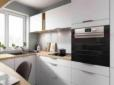

  PREDICTED_LABEL  SCORE_LABEL  image_quality  id_annonce
0      LivingRoom     0.574225       3.926912    36065749
e5976ffdca30df9e757e5829cad285cd51cfd12e.jpg


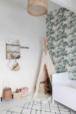

  PREDICTED_LABEL  SCORE_LABEL  image_quality  id_annonce
1        Bathroom      0.67775       4.130069    36065749
5dfb2e60d9bbe640fb91ecc0c1fcf3d1006f1eb3.jpg


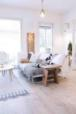

  PREDICTED_LABEL  SCORE_LABEL  image_quality  id_annonce
2         Bedroom     0.337189       3.189164    36065749
output.json
6163f8864fb397a8464b6fb4daa060e6b1fd1160.jpg


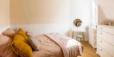

  PREDICTED_LABEL  SCORE_LABEL  image_quality  id_annonce
3        Bathroom     0.660778       3.230124    36065749
ea545e49cf1a417cf35af188357c204f1d43e1c6.jpg


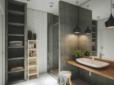

  PREDICTED_LABEL  SCORE_LABEL  image_quality  id_annonce
4        Bathroom     0.601082       3.023365    36065749


In [44]:
id_annonce="36065749"
for i in [x for x in os.walk("data/reduced_images/"+"test"+"/ann_"+id_annonce)][-1][-1]:
    print(i)
    if 'jpg' in i:
        display_image(X_test_images_full,i,id_annonce)

# Section IV :
Tout d'abord, nous allons définir les paramètres de prétraitement que nous allons appliquer à nos données brutes.

In [ ]:
preprocessing_parameters = {
    'drop_columns':["energy_performance_category","ghg_category"],
    'frequency_encoding':['city'],
    'quantile_encoding':[],
    'target_encoding':[],
    'constant_imputation_floor':True,
    'constant_imputation_exposition':False,
    'constant_imputation_rest':True,
    'iter_imputation':False,
    'mean_imputation':False,
    'mini_imputation':False,
    'add_polar_coordinates':True,
    'add_polar_rotation':True,
    'add_geo_pca':True,
    'apply_pca_geo':False,
    'add_geopopulation':False,
    'add_distance_to_city_center':False, #only tru when add geopulation is true
    'add_geo':False,
    'geodata':["index","num_train_station","num_night_club", "num_gas_station","user_ratings_total",'num_store'],#  
    'add_classification_quality':False,
    'images_features':[],
    'feature_transformation':False,
    'features_interactions':False,
    'hot_encoding':True,
    'standard_scaling':False,
    'robust_scaling':True,
    'power_scaling':False,
    'target_transformation':True,
}



Chargement des données et des paramètres des modèles

In [ ]:
X_train_0, Y_train_0, X_test_0, X_test_ids = load_data('data/')
xgb_params, lgb_params, cat_params=load_hyperparameters()

In [ ]:
X_train_1,Y_train_1, X_test_1 = preprocess(X_train_0, Y_train_0, X_test_0,preprocessing_parameters)

In [ ]:
tuned_models = {
    "xgboost":XGBRegressor(**xgb_params),
    "lgb":LGBMRegressor(**lgb_params),
    "cat":CatBoostRegressor(**cat_params, verbose=False),
}

for model_name, model in tuned_models.items():
    model.fit(X_train_1, Y_train_1)
    print(f"Finished Training {model_name}.")


Dernière étape

In [ ]:
weights = [2/20,7/20,10/20]

final_predictions_sum= (
    weights[0]*np.exp(tuned_models["xgboost"].predict(X_test_1)) +
    weights[1]*np.exp(tuned_models["lgb"].predict(X_test_1)) + 
    weights[2]*np.exp(tuned_models["cat"].predict(X_test_1)) 
    )

final_predictions=pd.Series(final_predictions_sum,name="price")
final_predictions.head()
final_submission = pd.concat([X_test_ids, final_predictions], axis=1)
final_submission.to_csv("data/final_submission.csv", index=False, header=True)
print("Finished submitting")

Résultas

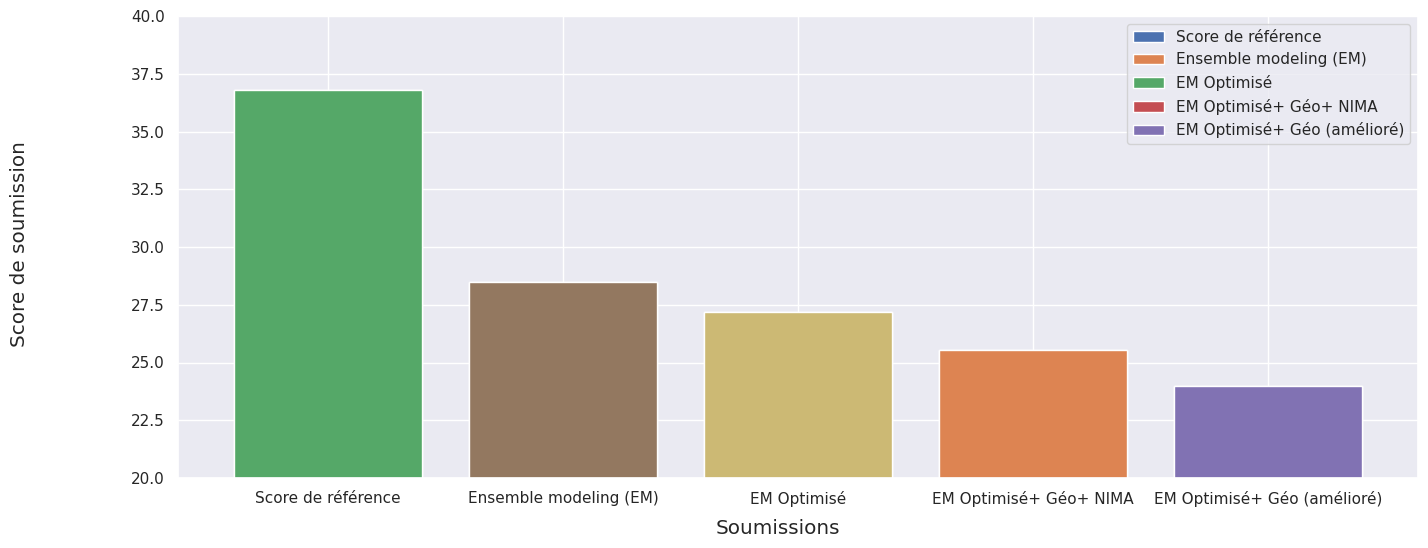

In [149]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt


X=['Score de référence','Ensemble modeling (EM)', 'EM Optimisé', 'EM Optimisé+ Géo+ NIMA', 'EM Optimisé+ Géo (amélioré)']
Y=[36.7811,28.4814035732235, 27.2051940078548, 25.543732440401, 24.002743844185]

fig, ax = plt.subplots()
ax.set_ylim([20, 40])

fig.set_size_inches(16, 6)
for x, y in zip(X,Y):
    ax.bar(x, y, label="MAE")
    ax.bar(x, y, label="MAE")
    ax.bar(x, y, label="MAE")

fig.supxlabel('Soumissions')
fig.supylabel('Score de soumission')
ax.legend(X)


## Notre meilleur score actuel est de 24.002743844185, ce qui nous place au 5e rang du classement public sur 162 soumissions (13 décembre).

In [1]:
!jupyter nbconvert --to html notebook.ipynb


[NbConvertApp] Converting notebook notebook.ipynb to html
[NbConvertApp] Writing 6830811 bytes to notebook.html
